Import /define prerquisites

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import scipy

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["axes.linewidth"] = 1  # set the value globally
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = "18"

import argparse
import glob, os, sys
import numpy as np

from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import lal, lalsimulation

import gw_eccentricity
import sxs

sys.path.insert(1, "/u/pjn/gitrepos/SurveyMeanAno/PlottingNotebooks")
import analysis_utils as au

%load_ext nb_black


# Some functions to plot the time domain modes
def AmpPhysicaltoNRTD(ampphysical, M, dMpc):
    return ampphysical * dMpc * 1e6 * lal.PC_SI / (lal.C_SI * (M * lal.MTSUN_SI))


def compute_freqInterp(time, hlm):
    philm = np.unwrap(np.angle(hlm))

    intrp = InterpolatedUnivariateSpline(time, philm)
    omegalm = intrp.derivative()(time)

    return omegalm


def SectotimeM(seconds, M):
    return seconds / (M * lal.MTSUN_SI)


# Function to compute amplitude, phase and frequency difference


def compute_phase_amp_om_diff(
    timeNRv4EHM,
    amplmv4EHM,
    phaselmv4EHM,
    omegalmv4EHM,
    timeNRv4HM,
    amplmv4HM,
    phaselmv4HM,
    omegalmv4HM,
    mode_list,
    align_start=True,
):
    timeCommon = {}
    phidiff = {}
    omdiff = {}
    ampdiff = {}
    for l, m in mode_list:
        # print(l,m)
        ttv4EHM = timeNRv4EHM
        ampv4EHM = amplmv4EHM[l, m]
        phv4EHM = phaselmv4EHM[l, m]
        omv4EHM = omegalmv4EHM[l, m]

        ttv4HM = timeNRv4HM
        ampv4HM = amplmv4HM[l, m]
        phv4HM = phaselmv4HM[l, m]
        omv4HM = omegalmv4HM[l, m]

        dtv4E = ttv4EHM[-1] - ttv4EHM[-2]
        dtv4 = ttv4HM[-1] - ttv4HM[-2]
        dt = min(dtv4E, dtv4)

        t0v4 = ttv4HM[0]
        t0v4E = ttv4EHM[0]

        tmin = max(t0v4, t0v4E)
        tmax = min(ttv4HM[-1], ttv4EHM[-1])

        timeCommon = np.arange(tmin, tmax, dt)

        iphv4 = InterpolatedUnivariateSpline(ttv4HM, phv4HM)
        iomv4 = InterpolatedUnivariateSpline(ttv4HM, omv4HM)
        iampv4 = InterpolatedUnivariateSpline(ttv4HM, ampv4HM)

        iphv4E = InterpolatedUnivariateSpline(ttv4EHM, phv4EHM)
        iomv4E = InterpolatedUnivariateSpline(ttv4EHM, omv4EHM)
        iampv4E = InterpolatedUnivariateSpline(ttv4EHM, ampv4EHM)

        if align_start == True:
            delta_phi0 = -iphv4(tmin) + iphv4E(tmin)

        else:
            tAlign = 0
            delta_phi0 = -iphv4(tAlign) + iphv4E(tAlign)

        phidiff[l, m] = iphv4E(timeCommon) - (iphv4(timeCommon) + delta_phi0)
        ampdiff[l, m] = iampv4E(timeCommon) - iampv4(timeCommon)
        omdiff[l, m] = iomv4E(timeCommon) - iomv4(timeCommon)

    return timeCommon, phidiff, omdiff, ampdiff


def waveform_to_frequency(waveform_dict):
    return -np.diff(np.unwrap(np.angle(waveform_dict["hlm"][(2, 2)]))) / np.diff(
        waveform_dict["t"]
    )


def compute_deriv_f(time, f):
    intrp = InterpolatedUnivariateSpline(time, f)
    deriv = intrp.derivative()(time)

    return deriv


def compute_deriv_f(time, f):
    intrp = InterpolatedUnivariateSpline(time, f)
    deriv = intrp.derivative()(time)

    return deriv


# Generate modes in NR units (rescaled by total mass of the system)
def SEOBNRv4EHM_modes_lightweight(
    q: float,
    chi1: float,
    chi2: float,
    eccentricity: float,
    eccentric_anomaly: float,
    f_min: float,
    M_fed: float,
    delta_t: float,
    EccIC: int,
    approx: str,
):
    # Some internal parameters of the model
    HypPphi0, HypR0, HypE0 = [0.0, 0, 0]

    EccFphiPNorder = 99
    EccFrPNorder = 99
    EccWaveformPNorder = 16
    EccBeta = 0.09
    Ecct0 = 100

    EccPNFactorizedForm = (
        EccNQCWaveform
    ) = EccPNRRForm = EccPNWfForm = EccAvNQCWaveform = 1
    EcctAppend = 40

    m1 = q / (1 + q) * M_fed
    m2 = 1 / (1 + q) * M_fed
    dMpc = 500
    dist = dMpc * (1e6 * lal.PC_SI)

    if approx == "SEOBNRv4E_opt" or approx == "SEOBNRv4E_opt1" or approx == "SEOBNRv4":
        SpinAlignedVersion = 4
        nqcCoeffsInput = lal.CreateREAL8Vector(
            10
        )  ##This will be unused, but it is necessary

    else:
        SpinAlignedVersion = 41
        nqcCoeffsInput = lal.CreateREAL8Vector(
            50
        )  ##This will be unused, but it is necessary

    if approx == "SEOBNRv4E_opt" or approx == "SEOBNRv4EHM_opt":
        sphtseries, dyn, dynHi = lalsimulation.SimIMRSpinAlignedEOBModesEcc_opt(
            delta_t,
            m1 * lal.MSUN_SI,
            m2 * lal.MSUN_SI,
            f_min,
            dist,
            chi1,
            chi2,
            eccentricity,
            eccentric_anomaly,
            SpinAlignedVersion,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            1.0,
            nqcCoeffsInput,
            0,
            EccFphiPNorder,
            EccFrPNorder,
            EccWaveformPNorder,
            EccPNFactorizedForm,
            EccBeta,
            Ecct0,
            EccNQCWaveform,
            EccPNRRForm,
            EccPNWfForm,
            EccAvNQCWaveform,
            EcctAppend,
            EccIC,
            HypPphi0,
            HypR0,
            HypE0,
        )

    # Faster version of the models with loosen ODE tolerances (be careful when using them!)
    elif approx == "SEOBNRv4E_opt1" or approx == "SEOBNRv4EHM_opt1":
        sphtseries, dyn, dynHi = lalsimulation.SimIMRSpinAlignedEOBModesEcc_opt1(
            delta_t,
            m1 * lal.MSUN_SI,
            m2 * lal.MSUN_SI,
            f_min,
            dist,
            chi1,
            chi2,
            eccentricity,
            eccentric_anomaly,
            SpinAlignedVersion,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            1.0,
            nqcCoeffsInput,
            0,
            EccFphiPNorder,
            EccFrPNorder,
            EccWaveformPNorder,
            EccPNFactorizedForm,
            EccBeta,
            Ecct0,
            EccNQCWaveform,
            EccPNRRForm,
            EccPNWfForm,
            EccAvNQCWaveform,
            EcctAppend,
            EccIC,
            HypPphi0,
            HypR0,
            HypE0,
        )

    else:
        # print("SEOBNRv4HM modes")
        sphtseries, dyn, dynHi = lalsimulation.SimIMRSpinAlignedEOBModes(
            delta_t,
            m1 * lal.MSUN_SI,
            m2 * lal.MSUN_SI,
            f_min,
            dist,
            chi1,
            chi2,
            SpinAlignedVersion,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            1.0,
            nqcCoeffsInput,
            0,
        )

    hlm = {}
    hlmC = {}

    if SpinAlignedVersion == 4:
        hlm[2, 2] = AmpPhysicaltoNRTD(sphtseries.mode.data.data, M_fed, dMpc)
        hlm[2, -2] = np.conjugate(hlm[2, 2])

    else:
        ##55 mode
        modeL = sphtseries.l
        modeM = sphtseries.m
        h55 = sphtseries.mode.data.data  # This is h_55
        # h55LAL = - h55 * np.exp^(-1.j * modeM * phi_ref)
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h55, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

        ##44 mode
        modeL = sphtseries.next.l
        modeM = sphtseries.next.m
        h44 = sphtseries.next.mode.data.data  # This is h_44
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h44, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

        ##21 mode
        modeL = sphtseries.next.next.l
        modeM = sphtseries.next.next.m
        h21 = sphtseries.next.next.mode.data.data  # This is h_21
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h21, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

        ##33 mode
        modeL = sphtseries.next.next.next.l
        modeM = sphtseries.next.next.next.m
        h33 = sphtseries.next.next.next.mode.data.data  # This is h_33
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h33, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

        ##22 mode
        modeL = sphtseries.next.next.next.next.l
        modeM = sphtseries.next.next.next.next.m
        h22 = sphtseries.next.next.next.next.mode.data.data  # This is h_22
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h22, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

    time_array = np.arange(0, len(hlm[2, 2]) * delta_t, delta_t)
    timeNR = SectotimeM(time_array, M_fed)

    imax = np.argmax(np.abs(hlm[2, 2]))
    timeNR -= timeNR[imax]

    return (
        timeNR,
        hlm,
    )

<IPython.core.display.Javascript object>

Helper to block error messages.

In [2]:
%%javascript
(function(on) {
    const e = $("<a>Setup failed</a>");
    const ns = "js_jupyter_suppress_warnings";
    var cssrules = $("#" + ns);
    if(!cssrules.length)
        cssrules = $("<style id='" + ns + "' type='text/css'>div.output_stderr { } </style>").appendTo("head");
    e.click(function() {
        var s = 'Showing';
        cssrules.empty()
        if(on) {
            s = 'Hiding';
            cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
        }
        e.text(s + ' warnings (click to toggle)');
        on = !on;
    }).click();
    $(element).append(e);
})(true);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load NR waveform and pass through gw_eccentricity.

In [3]:
nr_waveform = gw_eccentricity.load_data.load_sxs_catalogformat(
    filepath="/urania/ptmp/pjn/scratch_gitrepos/SimAnnex/Private/SurveyMeanAno/01/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5",
    num_orbits_to_remove_as_junk=2.0,
)
# Pass through once just so we can access apastron passages
nr_results = gw_eccentricity.gw_eccentricity.measure_eccentricity(
    fref_in=0.01080335 / (2 * np.pi), dataDict=nr_waveform
)

# Extract useful infor and pass through again, now at first available apastron passage
t_ref = nr_results["gwecc_object"].t_apocenters[0]
t_ref_2 = nr_results["gwecc_object"].t_apocenters[3]
start_ind = np.argmin(np.abs(nr_waveform["t"] - t_ref))
end_ind = np.argmin(np.abs(nr_waveform["t"] - t_ref_2))
t_for_omega22_avg, omega22_avg = nr_results["gwecc_object"].get_omega22_average()
ind = np.argmin(np.abs(t_for_omega22_avg - t_ref))
omega22_ref = omega22_avg[ind]
nr_results = gw_eccentricity.gw_eccentricity.measure_eccentricity(
    fref_in=omega22_ref / 2 / np.pi, dataDict=nr_waveform
)
nr_waveform["t"] = nr_waveform["t"][start_ind:end_ind] - nr_waveform["t"][start_ind]
nr_waveform["hlm"][(2, 2)] = nr_waveform["hlm"][(2, 2)][start_ind:end_ind]

<IPython.core.display.Javascript object>

For now hardcode parameters for EOB: In future, we can read these from metadata files.

In [4]:
q = 2.0
chi1, chi2 = 0.0, 0.0
Mtot = 40.0
delta_t = 1.0 / (4096.0) / 2.0
EccIC = -2
ecc_anomaly = nr_results["mean_anomaly"]
approx = "SEOBNRv4EHM_opt"

<IPython.core.display.Javascript object>

Define the function to fit over (i.e. finding EOB waveform closest to NR waveform): for now we will just fit the amplitude of the (2,2) mode.

In [5]:
def func(t, ecc_change, f_min_change):
    (
        timeNRv4EHM,
        hlmv4EHM,
    ) = SEOBNRv4EHM_modes_lightweight(
        q,
        chi1,
        chi2,
        nr_results["eccentricity"] * (1 + ecc_change / 100),
        ecc_anomaly,
        (1 + f_min_change / 100) * nr_results["fref_out"] / lal.MTSUN_SI / Mtot,
        Mtot,
        delta_t,
        EccIC,
        approx,
    )
    A_22_eob = np.abs(hlmv4EHM[2, 2])
    A_22_eob_interp = scipy.interpolate.interp1d(timeNRv4EHM - timeNRv4EHM[0], A_22_eob)
    return A_22_eob_interp(t)

<IPython.core.display.Javascript object>

Example of good parameters found by trial-and-error. Proof of concept more than anything.

In [6]:
test = func(
    nr_waveform["t"],
    0.5,
    -4,
)

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File

<IPython.core.display.Javascript object>

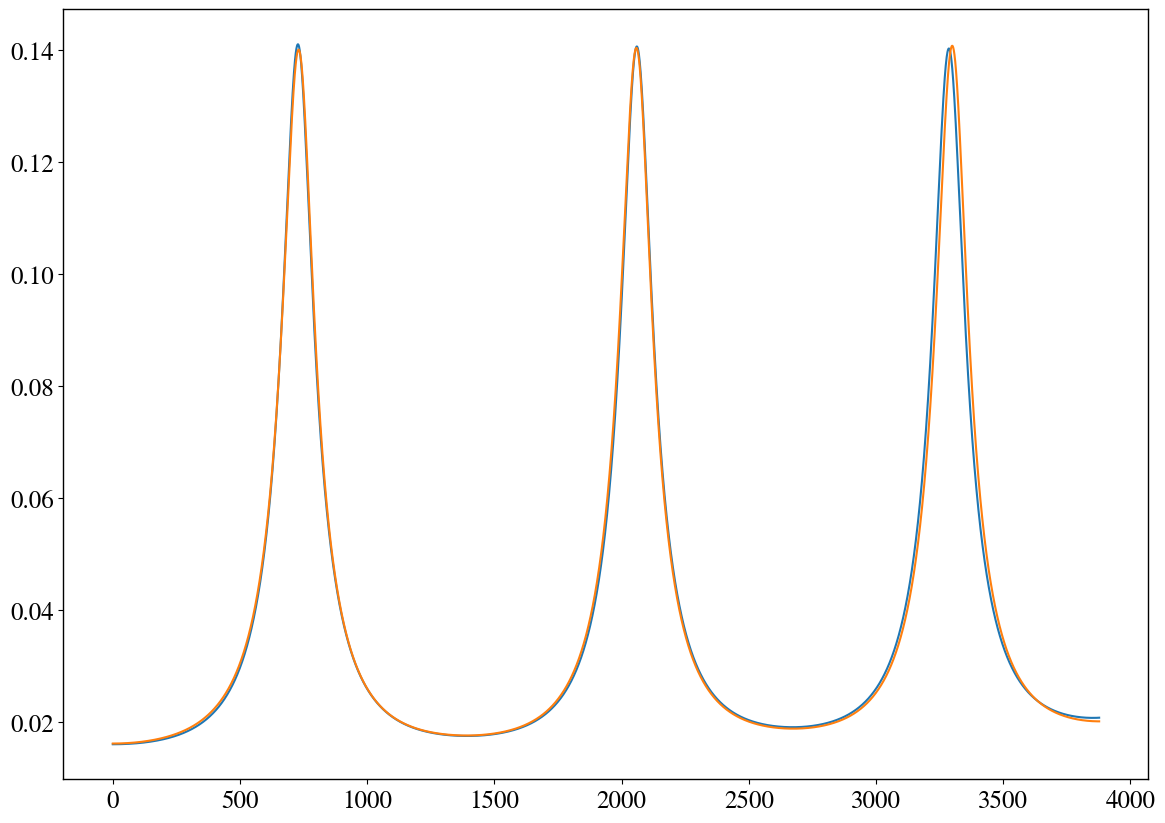

<IPython.core.display.Javascript object>

In [7]:
plt.plot(nr_waveform["t"], test)
plt.plot(nr_waveform["t"], np.abs(nr_waveform["hlm"][(2, 2)]))

Actually try doing the fit.

In [8]:
xtol, gtol, ftol = None, 1e-10, 1e-10
initial_guess = np.array([0., 0.])
best_guess = np.array([0.5, -4])

popt, pcov = scipy.optimize.curve_fit(func, nr_waveform["t"][::100], np.abs(nr_waveform["hlm"][(2, 2)])[::100], p0=initial_guess, bounds = ([-6, -6], [6, 6]), method="trf", gtol=gtol, xtol=xtol, ftol=ftol, verbose=2)


Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Excepti

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2700e-01                                    3.96e+02    


Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Excepti

       1              3         1.2699e-01      1.29e-05       6.59e-04       4.52e+03    


Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Excepti

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 325, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 326, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
Runtim

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 325, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 326, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/303282967

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed


       2             17         1.2699e-01      1.38e-07       2.46e-12       4.74e+03    


Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Excepti

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 325, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 326, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
Runtim

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 325, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 326, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/303282967

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBN

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception i

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 325, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 326, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
Ru

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ign

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 325, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 326, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdou

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 311, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 312, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 318, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 319, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File

Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Excepti

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 325, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3289638363.py", line 326, in SEOBNRv4EHM_modes_lightweight
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_COMPLEX16Vector'
Traceback (most recent call last):
  File "/tmp/ipykernel_3994/3032829676.py", line 5, in func
Runtim

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/u/pjn/conda-envs/laleob/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
  File "/tmp/ipykernel_3994/99982445.py", line 5, in <module>
    popt, pcov = scipy.optimize.curve_fit(func, nr_waveform["t"][::100], np.abs(nr_waveform["hlm"][(2, 2)])[::100], p0=initial_guess, bounds = ([-6, -6], [6, 6]), method="trf", gtol=gtol, xtol=xtol, ftol=ftol, verbose=2)
  File "/u/pjn/conda-envs/laleob/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py", line 870, in curve_fit
  File "/u/pjn/conda-envs/laleob/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py", line 938, in least_squares
  File "/u/pjn/conda-envs/laleob/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py", line 123, in trf
  File "/u/pjn/conda-envs/laleob/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py", line 338, in trf_bounds
  File "/u/pjn/conda-envs/laleob/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py",

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(
    nr_waveform["t"], func(nr_waveform["t"], *initial_guess), label="Before Curve Fit"
)

plt.plot(nr_waveform["t"], func(nr_waveform["t"], *popt), label="After Curve Fit")
plt.plot(nr_waveform["t"], np.abs(nr_waveform["hlm"][(2, 2)]), label="NR")
plt.legend()

In [ ]:
popt - initial_guess

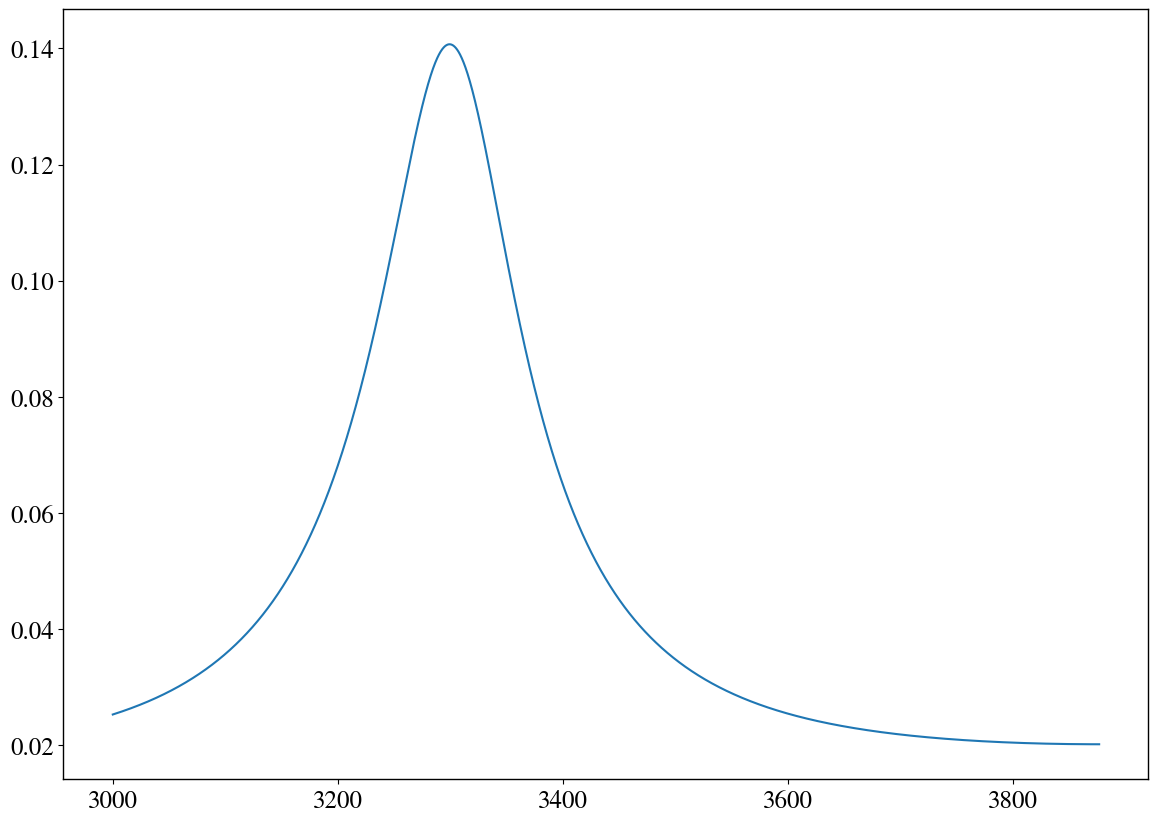

<IPython.core.display.Javascript object>

In [9]:
plt.plot(nr_waveform["t"][30000:-1], np.abs(nr_waveform["hlm"][(2, 2)])[30000:-1])